**Name: Willy Alberto Piñones Olivares**

**Student ID number:23430524**

**Task 1: Classification**

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

**1-** EDA-Exploratory Data Analysis

In [2]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [3]:
print('(number of examples, number of attributes):', df.shape)

(number of examples, number of attributes): (1338, 7)


In [4]:
df.dtypes

age                 int64
gender             object
bmi               float64
children            int64
smoker             object
region             object
insurance_cost    float64
dtype: object

we can check for missing values

In [5]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

we do not have missing values in our dataset.

In [6]:
df['insurance_cost'].value_counts()

insurance_cost
1639.56310     2
1725.55230     1
42211.13820    1
11033.66170    1
23568.27200    1
              ..
4949.75870     1
38711.00000    1
3756.62160     1
18765.87545    1
26926.51440    1
Name: count, Length: 1337, dtype: int64

We are going to replace the column **insurance_cost** with a binary column **'insurance_cost_binary'**, but first we are going to check the boxplots of the numercial columns for outliers.

In [7]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

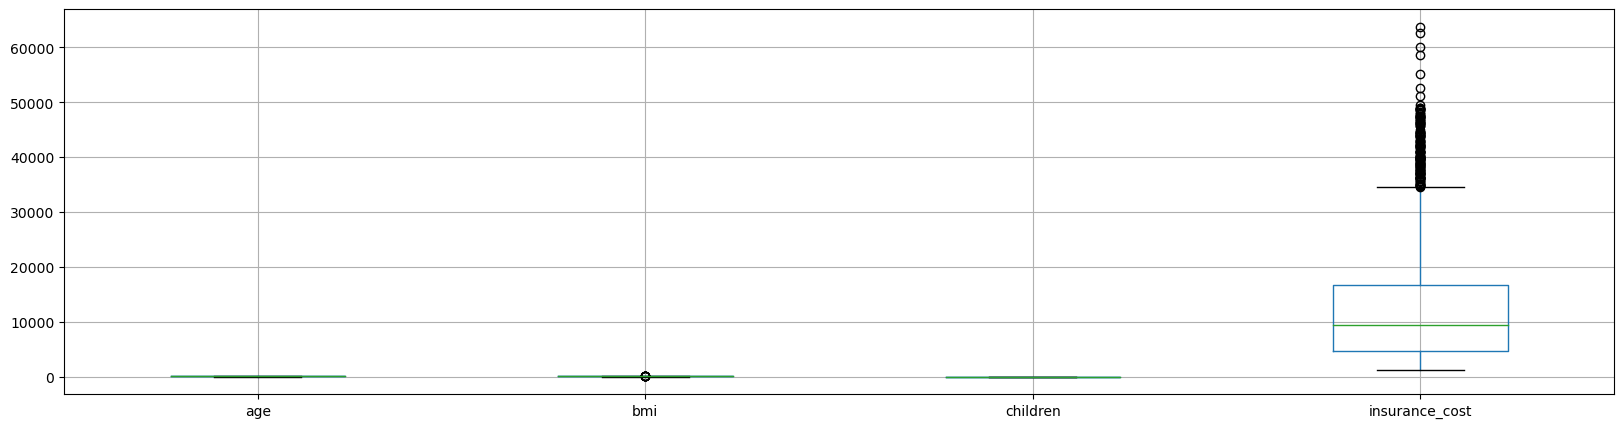

In [8]:
df.loc[:,'age':'insurance_cost'].boxplot(figsize=(20,5))
plt.show()

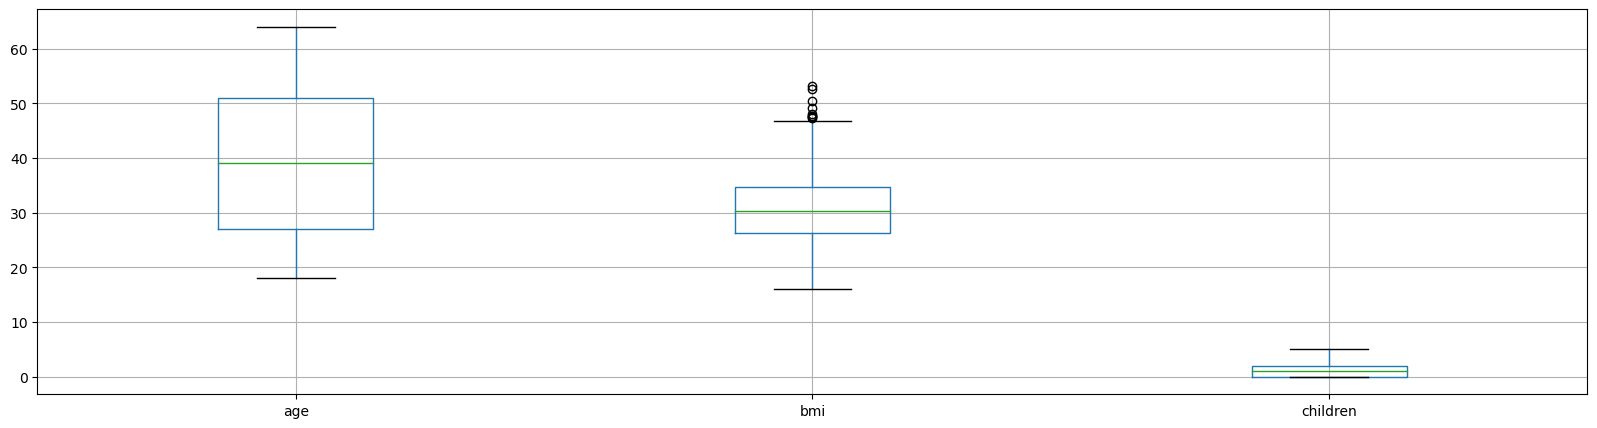

In [9]:
df.loc[:,'age':'region'].boxplot(figsize=(20,5))
plt.show()

we can see that **bmi** and **insurance_cost** have outliers. We will apply **RobustScaler** to them.
Let's also examine the histograms of all attributes.

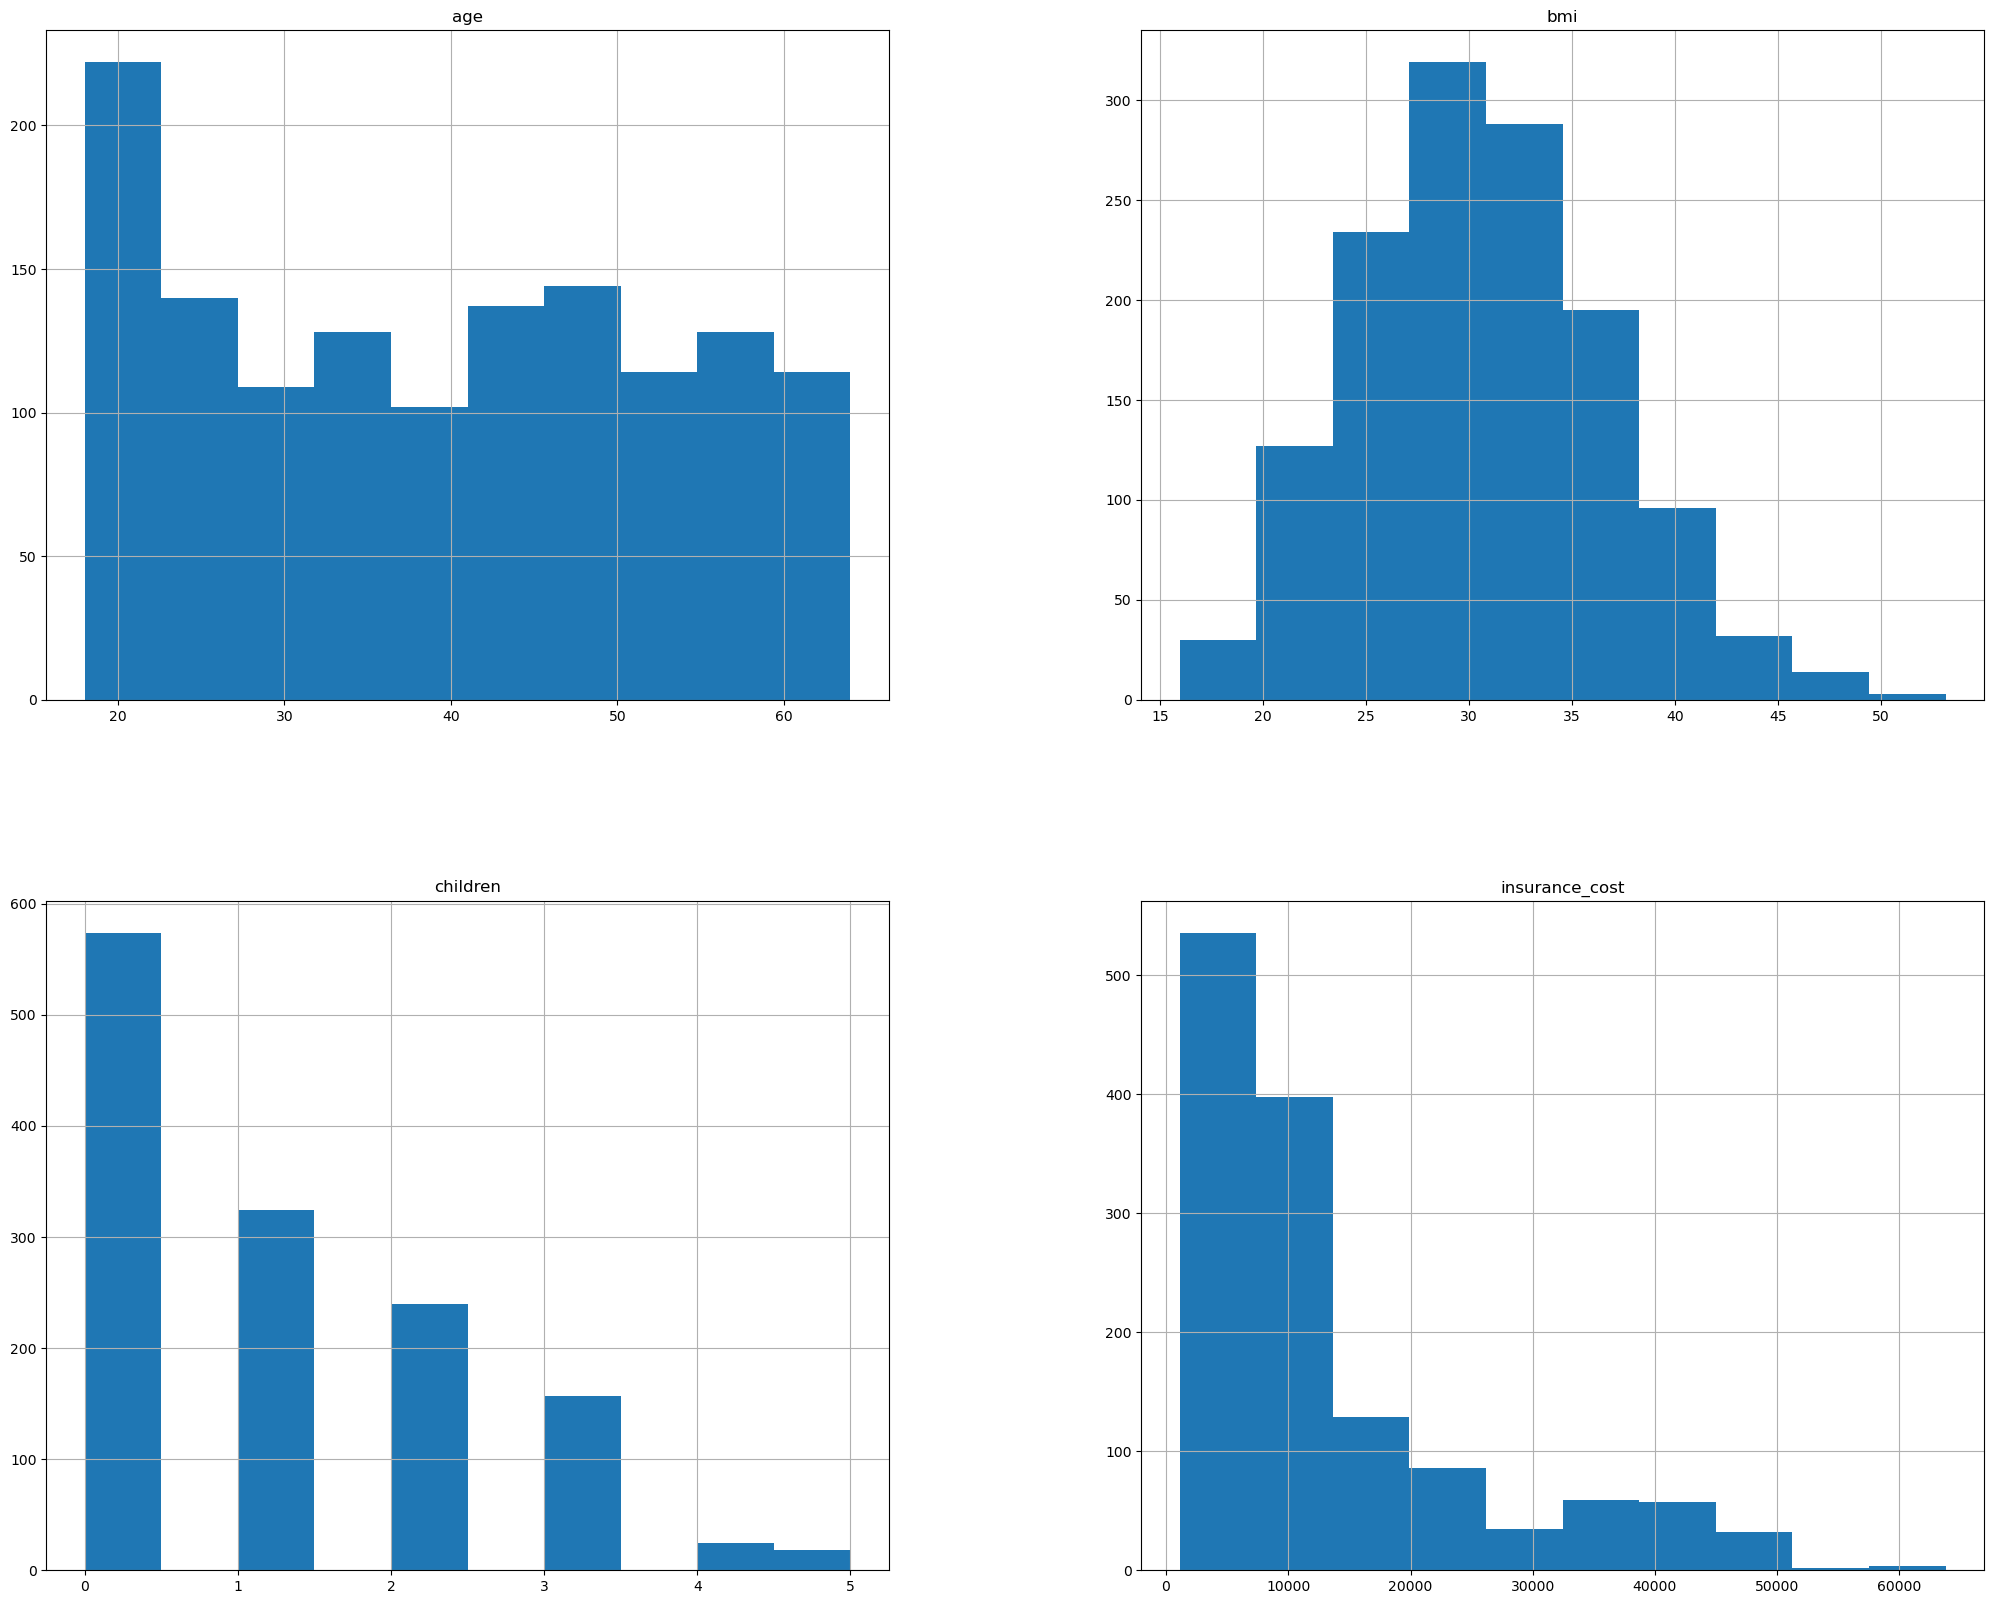

In [10]:
df.hist(bins=10, figsize=(25, 20));

we can see in the histograms above that **Children** and **insurance_cost** attributes have **skewed** to the right and we can apply **log transformation**. 

**2-** Data Preparation

Then, we can transform the **insurance_cost** columns to binary.

In [11]:
# Calculate the median insurance cost
median_insurance_cost = df['insurance_cost'].median()

# Use map function with a lamba function to create the binary column
df['insurance_cost_binary'] = df['insurance_cost'].map(lambda x:1 if x > median_insurance_cost else 0)

# Drop the original 'insurance_cost' column
df.drop('insurance_cost', axis=1, inplace=True)
print(df)

      age  gender     bmi  children smoker     region  insurance_cost_binary
0      18    male  33.770         1     no  southeast                      0
1      18    male  34.100         0     no  southeast                      0
2      18  female  26.315         0     no  northeast                      0
3      18  female  38.665         2     no  northeast                      0
4      18  female  35.625         0     no  northeast                      0
...   ...     ...     ...       ...    ...        ...                    ...
1333   64  female  31.825         2     no  northeast                      1
1334   64  female  26.885         0    yes  northwest                      1
1335   64    male  26.410         0     no  northeast                      1
1336   64    male  36.960         2    yes  southeast                      1
1337   64    male  23.760         0    yes  southeast                      1

[1338 rows x 7 columns]


Next, we split the columns into target **y** and predictors **X**

In [30]:
y = df['insurance_cost_binary']
X = df.drop('insurance_cost_binary', axis=1)

Now we are going to preprare a scikit-learn pipeline for data prepraration (preprocessing pipeline), which we apply later. The use of this piepelina ensures the preprocessing is applied separately to each training, validation, and test dataset, preventing data leakage.

First of all, we partition the **predictors** into three gropus, to wich we apply different data preparation

In [31]:
columns_outliers = ['bmi']
columns_rightskewed = ['age','children']
columns_categ = ['gender', 'smoker', 'region']




In [32]:
def custom_log_transform(X):
    min_additions = np.min(X, axis=0)
    min_additions[min_additions > 0] = 0
    X += np.abs(min_additions) + 1
    return np.log(X)

In [33]:
outliers_pipeline  = Pipeline(steps=[('scaler', RobustScaler())])

rightskewed_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('log_transform', FunctionTransformer(custom_log_transform))])

categ_pipeline  = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocess_pipeline = ColumnTransformer(transformers=[('outliers', outliers_pipeline, columns_outliers), ('rightskewed', rightskewed_pipeline, columns_rightskewed), ('categ', categ_pipeline, columns_categ)])
 


Now we can split the dataset into a training set and test sets.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1070 entries, 834 to 927
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1070 non-null   int64  
 1   gender    1070 non-null   object 
 2   bmi       1070 non-null   float64
 3   children  1070 non-null   int64  
 4   smoker    1070 non-null   object 
 5   region    1070 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 58.5+ KB


The parameter **stratify = y** ensures that the two classes are represented in the same proportion in both the training and test sets.

**3-** Model Training

**SVM**

Next, we train an **SVM** classification model with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation. To do this we build another pipeline, the **`main pipeline`**, which includes the preprocessing pipeline and the SVM classifier. The pipeline takes care of separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [36]:
# create the pipeline
pipe = Pipeline(steps=[('preproceess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

Let's visualise the main pipeline

In [37]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preproceess',
                 ColumnTransformer(transformers=[('outliers',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('rightskewed',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function custom_log_transform at 0x000001A62048FD80>))]),
                                                  ['age', 'children']),
                                                 ('categ',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('svm', SVC(probability=True))])

Then, we can train the model by exploring various combinations of values of the parameters of the predictor, such as SVM. Furthermore, we can also add parameters of the transformers to the parameters grid.

In [38]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.918:
Best parameters:  {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


In conclusion, we have the **best cross validation score** is 91.8% that can be considered good, on the other and, we have best parameters such as **svm_C : 10**, this means higher values of C result in a narrower margin, potenctially leading to better fit to the training data but risking overfitting.

**Ramdom Forest**

In [39]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

Let's visualise the main pipeline.

In [40]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('outliers',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('rightskewed',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function custom_log_transform at 0x000001A62048FD80>))]),
                                                  ['age', 'children']),
                                                 ('categ',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'smoker',
                                                   'region'])])),
                ('rf', RandomForestClassifier())])

Now, let'strain the model by exploring various combinations of values of the parameters of the predictor such as Ramdom Forest.

In [41]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.936:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 20}


In conclusion, we have the model achieved aprproximately **93.6%** acurracy accros all folds during **cross-validation**. Furthermore, **rf_max_depth :8** means that each decision tree in the random forest can have a maximum depth of 8 levels.

**4-** Comparare Classification Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline is automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same false positive rate (fpr) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1 and interpolate the true positive rate (tpr) for them.

In [42]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [43]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

Then, we can use the function above to evaluate the best **SVM** and **Random Forest** models found by the grid search.

In [44]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

Now, we can use a Pandas bar plot to compare the accuracies of both models as well as their precision, recall and F1-score for class 1.

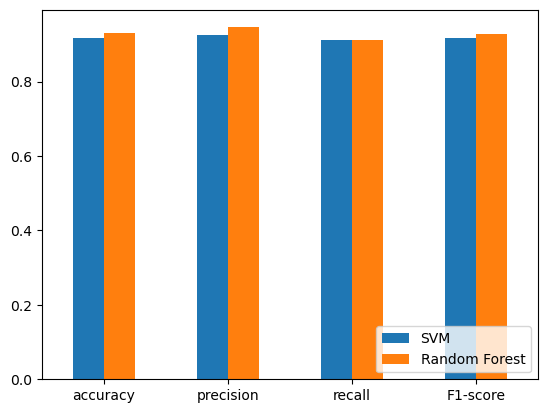

In [45]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

We can see in the graphic above that both classification models perform well but **Random Forest** being better. Therefore, we can pick **Random Forest** to train a final model on the whole dataset. These results will vary slightly when you rerun this notebook, if possible, the code could be enhanced to run the entire experiment multiple tiemes and average the results.

We can also examine the **ROC** curves of the two models for class 1.

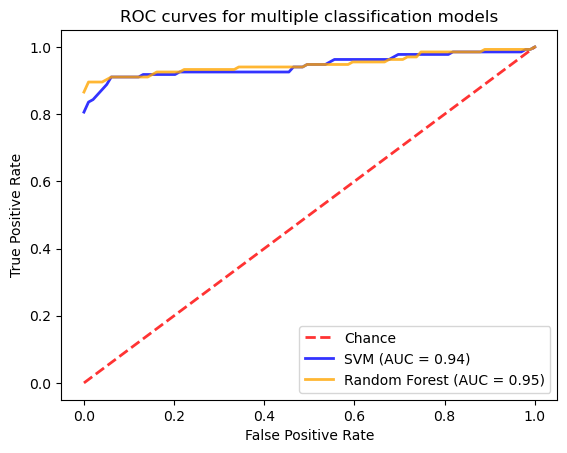

In [46]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

In conclusion, we can see in the graphic above that  model **Random Forest)** has AUC = 0.95, that means that model has strong performance, suggesting that **Random Forest** are effective in distinguishing between the positive and negative classes in the classification tasks. Furthermore, the model has excellent discrimination ability because have AUC score of 0.95, wich is very close to the maximum value of 1.

**5-** Train the Final Model

Finally, we can train a **Random Forest** model with all data we have, assuming that more data we have the better the model.

In [47]:
# function to remove the string 'rf__' from the names of the parameters in RF_best_params
def transform(dict):
    return {key.replace('rf__','') :  value for key, value in dict.items()}

# Construct the pipeline with Random Forest classifier
pipe = make_pipeline(preprocess_pipeline, RandomForestClassifier(**transform(RF_best_params)))

# Fit the final model
final_model =pipe.fit(X, y)

We can also store this model on disk and deploy later within a software system

In [48]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))